# Homework 2

## FINM 37400 - 2023

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

# 1 HBS Case: Fixed-Income Arbitrage in a Financial Crisis (A): US Treasuries in November 2008

## Data
* Use the data file `treasury_ts_2015-08-15.xlsx`.
* Examine the treasure issues with `kytreasno` of `204046` and `204047`. These are the bond and note (respectively) which mature on 2015-08-15.
* Look at the data on 2008-11-04.



In [52]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

In [53]:
filepath_rawdata = f'../data/treasury_ts_2015-08-15.xlsx'
case_rawdata = pd.read_excel(filepath_rawdata,sheet_name='database')
case_rawdata.columns = case_rawdata.columns.str.upper()
case_rawdata.set_index('KYTREASNO',inplace=True)
case_rawdata = case_rawdata.loc[[204046,204047],:]
case_rawdata = case_rawdata[case_rawdata.CALDT == "2008-11-04"]
case_rawdata

,KYCRSPID,CALDT,TDBID,TDASK,TDNOMPRC,TDNOMPRC_FLG,TDSOURCR,TDACCINT,TDRETNUA,TDYLD,TDDURATN,TDPUBOUT,TDTOTOUT,TDPDINT,TDIDXRATIO,TDIDXRATIO_FLG
KYTREASNO,,,,,,,,,,,,,,,,
204046,2.015082e+07,2008-11-04,141.859375,141.890625,141.87500,M,X,2.338655,0.009720,0.000098,1910.307862,2852.0,4024.0,0.0,NaN,NaN
204047,2.015082e+07,2008-11-04,105.953125,105.984375,105.96875,M,X,0.935462,0.011642,0.000089,2168.016569,20998.0,32470.0,0.0,NaN,NaN


## 1.1 The situation

Make a chart comparing the issues in the following features, (as of Nov 4, 2008.)
* coupon rate
* bid
* ask
* accrued interest
* dirty price
* duration (quoted in years, not days, assuming 365.25 days per year.)
* modified duration
* YTM



In [54]:
metrics = case_rawdata.copy()[['TDASK','TDBID','TDDURATN','TDACCINT','TDYLD']]
metrics.columns = ["ask", "bid",'duration','Accrued interest','YTM']
metrics['YTM'] *= 365.25
metrics['coupon rate'] = [10.625,4.25]
metrics['duration'] /= 365.25
metrics['modified duration'] = metrics['duration']/(1+metrics['YTM']/2)
metrics['dirty price'] = (case_rawdata['TDBID'] + case_rawdata['TDASK'])/2 + case_rawdata['TDACCINT']
metrics

,ask,bid,duration,Accrued interest,YTM,coupon rate,modified duration,dirty price
KYTREASNO,,,,,,,,
204046,141.890625,141.859375,5.230138,2.338655,0.035753,10.625,5.138284,144.213655
204047,105.984375,105.953125,5.935706,0.935462,0.032362,4.250,5.841189,106.904212


## 1.2 Hedge Ratio

Suppose you are building a trade to go long $n_i$ bonds (`204046`) and short $n_j$ notes (`204047`).

We can find an equation for $n_j$ in terms of $n_i$ such that the total holdings will have duration equal to zero. (Having zero duration also means have zero dollar duration, if helpful.)

Notation:
* $n_i$: number of bonds purchased (or sold)
* $D_i$: duration of bond $i$
* $D_{\$,i}$: dollar duration of bond $i$, equal to $p_iD_i$

If we want the total duration of our holdings to be zero, then we need to size the trade such that $n_i$ and $n_j$ satisfy,

$$0 = n_iD_{\$,i} + n_jD_{\$,j}$$

$$n_j = -n_i\frac{D_{\$,i}}{D_{\$,j}}$$

Suppose you will use \\$1mm of capital, leveraged 50x to buy \\$50mm of the bonds (`204046`).

Use the ratio above to short a number of notes (`204047`) to keep zero duration.

Report the number of bonds and notes of your position, along with the total dollars in the short position.

In [55]:
n_46 = 50000000/metrics.loc[204046,"dirty price"]
n_47 = -n_46*metrics.loc[204046,"duration"]/metrics.loc[204047,"duration"]
print("204046: "+str(n_46))
print("204047: "+str(n_47))
print("total dollar: "+ str(n_47*metrics.loc[204047,"dirty price"]))

204046: 346707.8068140331
204047: -305495.19713164
total dollar: -32658723.305860233


## 1.3 Profit Opportunity

Using the concept of **modified duration**, how much profit or loss (PnL) would you expect to make for every basis point of convergence in the spread? Specifically, assume the convergence is symmetric: the bond's (`204046`) ytm goes down 0.5bp and the note (`204047`) ytm goes up 0.5bp.

Describe the PnL you would expect to achieve on your position should this happen. Specify the PnL of the long position, the short position, and the net total.

Suppose the spread in YTM between the two securities disappears, due to a symmetric move of roughly ~17bps in each security's YTM. What is the PnL? (This is just a linearly scaling of your prior answer for a 1bp convergence.) 


In [56]:
# Calculate PnL for 1 basis point of convergency in the spread
# dp_duration = dirty_price * (-modified_duration * dr) * (1+YTM/2)

ytm_204046 = metrics.loc[204046,"YTM"]
dirty_price_204046 = metrics.loc[204046,"dirty price"]
modified_duration_204046 = metrics.loc[204046,"modified duration"]
dr = -0.00005
dp_204046 = -1 * (1+ytm_204046/2) * dirty_price_204046 * dr * modified_duration_204046

ytm_204047 = metrics.loc[204047,"YTM"]
dirty_price_204047 = metrics.loc[204047,"dirty price"]
modified_duration_204047 = metrics.loc[204047,"modified duration"]
dr = 0.00005
dp_204047 = -1 * (1+ytm_204047/2) * dirty_price_204047 * dr * modified_duration_204047

pnl_long = n_46 * dp_204046
print("PnL long 204046: " +  str(pnl_long))

pnl_short = n_47 * dp_204047
print("PnL short 204047: " +  str(pnl_short))

pnl = pnl_long + pnl_short
print("Net total PnL: " + str(pnl))

PnL long 204046: 13075.34470653662
PnL short 204047: 9692.628780303234
Net total PnL: 22767.973486839852


In [57]:
# Spread in YTM between two securities disappears (~17bps in each security YTM)

pnl_nospread = pnl * 34
print("No-spread in YTM PnL: " + str(pnl_nospread))

No-spread in YTM PnL: 774111.098552555




## 1.4 Result in 2008

Calculate the profit (or loss) on the position on the following two dates:
* 2008-11-25
* 2008-12-16

To calculate the pnl on each date, simply use the prices of the securities on those dates along with your position sizes, ($n_i, n_j$). No coupon is being paid in November or December, so all you need is the "dirty" price on these two dates.

Does the pnl make sense (approximately) given your results in 1.3 with regard to the sensitivity of pnl to moves in the YTM spread?


In [58]:
filepath_rawdata = f'../data/treasury_ts_2015-08-15.xlsx'
df1 = pd.read_excel(filepath_rawdata,sheet_name='database')
df1.columns = df1.columns.str.upper()
df1.set_index('KYTREASNO',inplace=True)
df1 = df1.loc[[204046,204047],:]
df1 = df1[df1.CALDT == "2008-11-25"]

df2 = pd.read_excel(filepath_rawdata,sheet_name='database')
df2.columns = df2.columns.str.upper()
df2.set_index('KYTREASNO',inplace=True)
df2 = df2.loc[[204046,204047],:]
df2 = df2[df2.CALDT == "2008-12-26"]

In [59]:
print("2008-11-04")
metrics

2008-11-04


,ask,bid,duration,Accrued interest,YTM,coupon rate,modified duration,dirty price
KYTREASNO,,,,,,,,
204046,141.890625,141.859375,5.230138,2.338655,0.035753,10.625,5.138284,144.213655
204047,105.984375,105.953125,5.935706,0.935462,0.032362,4.250,5.841189,106.904212


In [60]:
df1 = df1.copy()[['TDASK','TDBID','TDDURATN','TDACCINT','TDYLD']]
df1['dirty price'] = (df1['TDBID'] + df1['TDASK'])/2 + df1['TDACCINT']
df1['YTM'] = df1['TDYLD']*365
print("2008-11-25")
df1

2008-11-25


,TDASK,TDBID,TDDURATN,TDACCINT,TDYLD,dirty price,YTM
KYTREASNO,,,,,,,
204046,145.890625,145.859375,1898.970318,2.944973,0.000082,148.819973,0.030066
204047,110.828125,110.796875,2155.590747,1.177989,0.000068,111.990489,0.024770


In [61]:
df2 = df2.copy()[['TDASK','TDBID','TDDURATN','TDACCINT','TDYLD']]
df2['dirty price'] = (df2['TDBID'] + df2['TDASK'])/2 + df2['TDACCINT']
df2['YTM'] = df2['TDYLD']*365
print("2008-12-16")
df2

2008-12-16


,TDASK,TDBID,TDDURATN,TDACCINT,TDYLD,dirty price,YTM
KYTREASNO,,,,,,,
204046,151.81250,151.78125,1881.774790,3.840014,0.000060,155.636889,0.021843
204047,116.84375,116.81250,2134.622761,1.536005,0.000043,118.364130,0.015644


In [62]:
p_46_1104 = metrics.loc[204046,'dirty price']
p_46_1125 = df1.loc[204046,'dirty price']
p_46_1216 = df2.loc[204046,'dirty price']

p_47_1104 = metrics.loc[204047,'dirty price']
p_47_1125 = df1.loc[204047,'dirty price']
p_47_1216 = df2.loc[204047,'dirty price']

pnl_1125 = n_46 * (p_46_1125 - p_46_1104) + n_47 * (p_47_1125 - p_47_1104)
print("PnL 2008-11-25: " + str(pnl_1125))

pnl_1216 = n_46 * (p_46_1216 - p_46_1104) + n_47 * (p_47_1216 - p_47_1104)
print("PnL 2008-12-16: " + str(pnl_1216))

PnL 2008-11-25: 43213.140745888464
PnL 2008-12-16: 459574.2467148765


The pnl make sense given my results in 1.3 (last problem). For last question, we compute that for negative 0.5bps change in 204046 YTM, the pnl for long position will be 13075. And for positive 0.5bps change in 204647 YTM, the pnl for short position will be 9692.

Here, for example, on date 2008-11-25, the change in 204046 YTM is -57 bps and the change in 204047 YTM is -75 bps. So approximately the pnl based on 1.3 will be 13075 * 57 * 2 + (-9692) * 75 * 2 = ~37000 which is close to 43213 above.



## 1.5 *Optional*: Examining the Trade through June 2009

Calculate the pnl of the trade for the following dates:
* 2009-01-27
* 2009-03-24
* 2009-06-16

Did the trade do well or poorly in the first six months of 2009?

Calculate the YTM spreads on these dates. Does the YTM spread correspond to pnl roughly as we would expect based on the calculation in 1.3?

***

# 2 Calculating Duration

Use the data file `../data/treasury_quotes_2022-09-30.xlsx`.

This data reports duration as `TDDURATN`. It quotes the duration in days, so I recommend dividing by 365 to get the duration in its usual format.



 

In [63]:
filepath_rawdata = f'../data/treasury_quotes_2022-09-30.xlsx'
rawdata = pd.read_excel(filepath_rawdata,sheet_name='quotes')
rawdata.columns = rawdata.columns.str.upper()
rawdata.set_index('KYTREASNO',inplace=True)
rawdata.sort_values('TMATDT',inplace=True)
t_check = rawdata['CALDT'].values[0]
if rawdata['CALDT'].eq(t_check).all():
    t_current = t_check
else:
    warnings.warn('Quotes are from multiple dates.')
    t_current = None
metrics = rawdata.copy()[['TDATDT','TMATDT','TCOUPRT','TDYLD','TDDURATN','TDPUBOUT']]
metrics.columns = ['issue date','maturity date','coupon rate','ytm','duration','outstanding']
metrics['ytm'] *= 365
metrics['duration'] /= 365
metrics['outstanding'] *= 1e6
metrics['maturity'] = get_maturity_delta(metrics['maturity date'], t_current)
metrics['price'] = (rawdata['TDBID'] + rawdata['TDASK'])/2 + rawdata['TDACCINT']
metrics['ask-bid'] = rawdata['TDASK'] - rawdata['TDBID']
metrics['next cashflow date'] = (calc_cashflows(rawdata) != 0).idxmax(1)
metrics = metrics[['issue date','maturity date','maturity','coupon rate','next cashflow date','price','ytm','ask-bid','duration']]
metrics

,issue date,maturity date,maturity,coupon rate,next cashflow date,price,ytm,ask-bid,duration
KYTREASNO,,,,,,,,,
207892,2022-06-07,2022-10-04,0.010951,0.000,2022-10-04,99.973389,0.024286,0.000111,0.010959
207774,2021-10-07,2022-10-06,0.016427,0.000,2022-10-06,99.961000,0.023730,0.000167,0.016438
207893,2022-06-14,2022-10-11,0.030116,0.000,2022-10-11,99.925139,0.024850,0.000306,0.030137
207868,2022-04-14,2022-10-13,0.035592,0.000,2022-10-13,99.907736,0.025917,0.000361,0.035616
207430,2019-10-15,2022-10-15,0.041068,1.375,2022-10-15,100.568648,0.028740,0.031250,0.041096
...,...,...,...,...,...,...,...,...,...
207808,2021-11-15,2051-11-15,29.125257,1.875,2022-11-15,66.640625,0.037857,0.046875,20.506232
207849,2022-02-15,2052-02-15,29.377139,2.250,2023-02-15,72.718750,0.037800,0.062500,19.982853
207850,2022-02-15,2052-02-15,29.377139,0.125,2023-02-15,62.910156,NaN,0.257812,NaN



## 2.1 
Set up the cashflow matrix. 

In [64]:
CF = calc_cashflows(rawdata)
prices = metrics['price'][CF.index]

CFset = {'all dates, including negative YTM quotes':CF}
display(CF)

,2022-10-04,2022-10-06,2022-10-11,2022-10-13,2022-10-15,2022-10-18,2022-10-20,2022-10-25,2022-10-27,2022-10-30,...,2050-05-15,2050-08-15,2050-11-15,2051-02-15,2051-05-15,2051-08-15,2051-11-15,2052-02-15,2052-05-15,2052-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207892,100.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
207774,0.0,100.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
207893,0.0,0.0,100.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
207868,0.0,0.0,0.0,100.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
207430,0.0,0.0,0.0,0.0,100.6875,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207808,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.9375,0.0000,0.9375,0.0000,0.9375,0.0000,100.9375,0.0000,0.0000,0.0
207849,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,1.1250,0.0000,1.1250,0.0000,1.1250,0.0000,101.1250,0.0000,0.0
207850,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0625,0.0000,0.0625,0.0000,0.0625,0.0000,100.0625,0.0000,0.0


## 2.2
Build a discount curve assuming that the spot rate is 2\% per year, continuously compounded.

Plot the discount curve and the associated spot curve out to 30 years maturity.

*Note, you do not need to properly extract a spot curve and associated discount factors; rather, you are simply assuming a flat term structure of spot rates at 2\% and using that to figure out discount rates.*



Text(0.5, 1.0, 'discount curve')

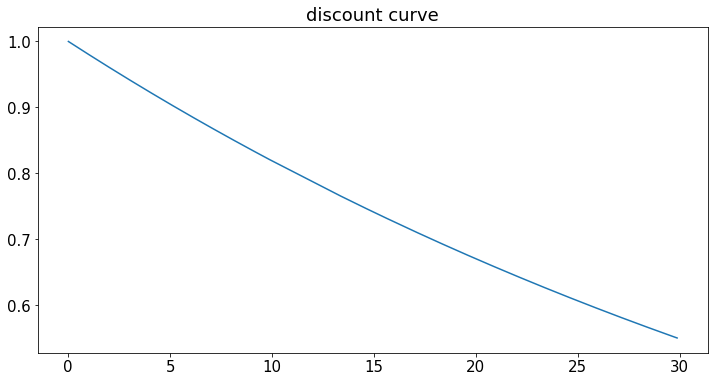

In [65]:
r = 0.02
discount = np.exp(-r*metrics["maturity"])
plt.plot(metrics["maturity"],discount)
plt.title("discount curve")

Text(0.5, 1.0, 'spot curve')

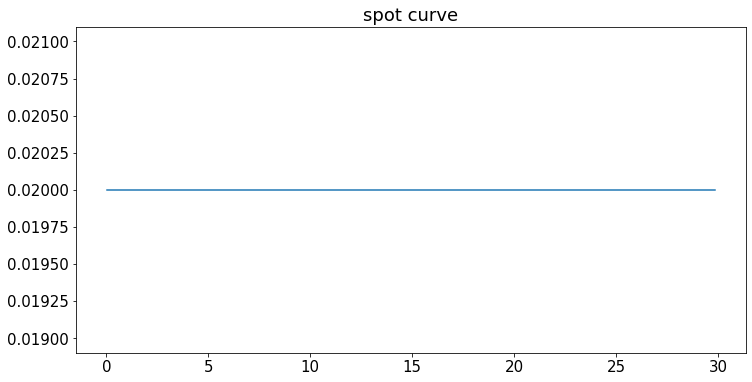

In [66]:
spot = [0.02 for i in range(len(metrics["maturity"]))]
plt.plot(metrics["maturity"],spot)
plt.title("spot curve")

## 2.3
For each treasury issue, calculate the duration as the weighted average of the (discounted!) cashflow maturity.

Report the summary statistics of the durations. (Use `.describe()` from pandas.)




In [67]:
CF_prices = CF * np.array(discount).reshape(-1,1)
model_prices = CF_prices.sum(axis=1)

CF_wts = CF_prices.div(model_prices,axis=0)
display(CF_wts.iloc[-5:,-10:].style.format('{:.2%}'))

CF_intervals = get_maturity_delta(CF.columns.to_series(),t_current)
model_duration = (CF_wts * CF_intervals).sum(axis=1)

,2050-05-15 00:00:00,2050-08-15 00:00:00,2050-11-15 00:00:00,2051-02-15 00:00:00,2051-05-15 00:00:00,2051-08-15 00:00:00,2051-11-15 00:00:00,2052-02-15 00:00:00,2052-05-15 00:00:00,2052-08-15 00:00:00
KYTREASNO,,,,,,,,,,
207808,0.60%,0.00%,0.60%,0.00%,0.60%,0.00%,64.99%,0.00%,0.00%,0.00%
207849,0.00%,0.68%,0.00%,0.68%,0.00%,0.68%,0.00%,60.78%,0.00%,0.00%
207850,0.00%,0.06%,0.00%,0.06%,0.00%,0.06%,0.00%,96.50%,0.00%,0.00%
207891,0.77%,0.00%,0.77%,0.00%,0.77%,0.00%,0.77%,0.00%,54.46%,0.00%
207934,0.00%,0.79%,0.00%,0.79%,0.00%,0.79%,0.00%,0.79%,0.00%,53.42%


In [68]:
model_duration.describe()

count    427.000000
mean       5.762745
std        6.732948
min        0.010951
25%        1.026226
50%        3.117846
75%        6.331722
max       28.861436
dtype: float64

## 2.4
How close are your duration estimates to the imputed durations given in the data source, (column `TDDURATN`)?

Report the summary statistics of the imputed durations minus your calculated durations from above.

Why might they be different?


In [69]:
diff = model_duration - metrics["duration"]
diff.describe()

count    378.000000
mean       0.397590
std        0.885709
min       -0.001308
25%       -0.000231
50%        0.002560
75%        0.062438
max        3.891592
dtype: float64

The calculated data is very similar to the imupted version, with some sligh different in the process. The difference has a mean of 0.4 and most of the difference is less than 0.01. Possible reason for this is that the discount rate we used is based on assumption of 2% spot rate, which might not be the exact case. 


## 2.5
Continue using your assumed discount rates of 2\% to calculate the convexity of each issue.

Report the summary statistics of these convexity calculations.


In [70]:
model_convextivity = (CF_wts * (CF_intervals**2)).sum(axis=1)
model_convextivity.describe()

count    427.000000
mean      86.796905
std      166.548469
min        0.000120
25%        1.053704
50%        9.953203
75%       42.414258
max      842.773025
dtype: float64


## 2.6 (Optional)

Re-do the duration and convexity calculations using an extracted discount curve instead of a discount curve based on a constant (arbitrary) spot rate.

# 3 Hedging Duration

Import `treasury_ts_issue_duration_(207392, 207391, 207457).xlsx`.

I suggest using code such as

* `tsdata = pd.read_excel(filepath_tsdata,sheet_name='ts')`

* `tsdata.columns = tsdata.columns.str.upper()`

* `px = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDASK').dropna()`
* `duration = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDDURATN').dropna()`





In [71]:
filepath_tsdata = "../data/treasury_ts_issue_duration_(207392, 207391, 207457).xlsx"

tsdata = pd.read_excel(filepath_tsdata,sheet_name='ts')
tsdata.columns = tsdata.columns.str.upper()
px = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDASK').dropna()
duration = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDDURATN').dropna()

## 3.1 

Suppose you have a portfolio of 10,000 USD long in security `207391` on the last day of the sample.

If you want to manage interest rate exposure using duration, how large of a short position should you hold in `207392`?

(Duration is the column `TDDURATN` in the raw data.)

In [72]:
n_91 = 10000/px.loc["2022-05-31",207391]
n_92 = -n_91*duration.loc["2022-05-31",207391]/duration.loc["2022-05-31",207392]
print("Long 207391: "+str(n_91))
print("Short 207392: "+str(n_92))

Long 207391: 108.49296490930666
Short 207392: -37.512712052913


## 3.2

Step through the time-series, doing the following:

* Starting at the end of the first day, set the hedged position according to the relative given durations.
* Use the second day's price data to evaluate the net profit or loss of the hedged position.
* Reset the the hedged position using the end-of-second-day durations. Again fix the long position of security `207391` to be 10,000.
* Repeat throughout the timeseries.

Report 
* the total profit (or loss.)
* the mean, standard deviation, min, and max of the daily profit or loss.

In [73]:
# dp_duration = price * (-duration * dr)

pnl = pd.DataFrame(dtype=float, index=px.index)
pnl = pnl.rename_axis(index=None)
pnl['Long'] = 10000/px[207391]
pnl['Short'] = -pnl['Long']*duration[207391]/duration[207392]
pnl['Today price 207391'] = px[207391]
pnl['Today price 207392'] = px[207392]
pnl['Next day price 207391'] = px[207391].shift(-1)
pnl['Next day price 207392'] = px[207392].shift(-1)
pnl['PnL'] = pnl['Long'] * (pnl['Next day price 207391']-pnl['Today price 207391'])\
            + pnl['Short'] * (pnl['Next day price 207392']-pnl['Today price 207392'])
pnl

,Long,Short,Today price 207391,Today price 207392,Next day price 207391,Next day price 207392,PnL
2019-12-10,101.967657,-42.137448,98.070312,99.656250,98.507812,100.492188,9.386577
2019-12-11,101.514791,-41.876324,98.507812,100.492188,97.632812,98.687500,-13.251763
2019-12-12,102.424582,-42.391876,97.632812,98.687500,98.242188,99.968750,8.100389
2019-12-13,101.789264,-42.016185,98.242188,99.968750,97.851562,99.210938,-7.921041
2019-12-16,102.195609,-42.222506,97.851562,99.210938,97.742188,98.796875,6.305112
...,...,...,...,...,...,...,...
2022-05-24,107.789474,-37.191499,92.773438,85.382812,92.875000,85.531250,5.426755
2022-05-25,107.671602,-37.129254,92.875000,85.531250,92.867188,84.976562,19.753949
2022-05-26,107.680660,-37.176465,92.867188,84.976562,92.828125,85.265625,-14.952598
2022-05-27,107.725972,-37.152578,92.828125,85.265625,92.171875,83.843750,-17.868847


In [74]:
pnl_total = pnl['PnL'].sum()
print("PnL Total: " + str(pnl_total))

pnl_mean = pnl['PnL'].mean()
print("PnL Mean: " + str(pnl_mean))

pnl_std = pnl['PnL'].std()
print("PnL Std: " + str(pnl_std))

pnl_max = pnl['PnL'].max()
print("PnL Maximum: " + str(pnl_max))

pnl_min = pnl['PnL'].min()
print("PnL Minimum: " + str(pnl_min))

PnL Total: -158.5991325925155
PnL Mean: -0.2558050525685734
PnL Std: 20.760299556995275
PnL Maximum: 112.87440242958345
PnL Minimum: -126.07854804542521


***

# 4 Other Interest-Rate Risks

## *Optional*

***No need to submit this problem, but if we discuss it, then you are expected to know it.***

## 4.1 Other Yield Curve Movements

Use the yield curve time-series data in `'../data/yields_2022-11-30.xlsx` to calculate the time-series of the **level**, **slope**, and curvature** factors.

Calculate the yield-curve factors. For each point in time, calculate the following three factors:

$\begin{align}
x^{\text{level}}_t =& \frac{1}{N_{\text{yields}}}\sum_{i=1}^{N_{\text{yields}}} y^{(i)}_t\\
x^{\text{slope}}_t =& y^{(30)}_t - y^{(1)}_t\\
x^{\text{curvature}}_t =& -y^{(1)}_t + 2 y^{(10)}_t - y^{(30)}_t
\end{align}$

Report the mean and volatility of each factor.

Report the correlation matrix of the factors.

## 4.2 Factor Duration

Calculate the factor duration of the treasuries from `treasury_ts_issue_duration_(207392, 207391, 207457).xlsx`.

Run a multivariate regression of the bond prices on all three factors constructed above from the yield factors: level, slope, and curvature. 

Estimate the regression in the form of day-over-day differences for both bond prices and factors. That is, we are using regression to approximate the factor duration equation,

$\begin{align}
\frac{dP}{P} = \beta_1 dz_1 + \beta_2 dz_2 + \beta_3 dz_3 + \epsilon
\end{align}$

Report the betas for each of these factors, for each of the bond prices.